### Evaluating the models

In [2]:
#import all the necessary libraries
import warnings
warnings.filterwarnings("ignore")

from numpy import mean
from numpy import std
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
import matplotlib.pyplot as plt



Bad key "text.kerning_factor" on line 4 in
/Users/HOME/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
#load the data
df = pd.read_csv('/Users/HOME/Desktop/LosAngelesCrime/data/preprocess_output.csv',index_col = 0)
df.head()

area_name_0  area_name_1  area_name_2  area_name_3  area_name_4  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            1   
4            0            0            0            0            1   

   area_name_5  crm_cd crm_cd_desc  vict_age  vict_sex_0  ...  location_13  \
0            1     648       ARSON        48           0  ...            0   
1            1     648       ARSON        35           0  ...            1   
2            1     648       ARSON        37           0  ...            1   
3            0     648       ARSON         0           0  ...            0   
4            0     648       ARSON        16           0  ...            0   

   location_14      lat       lon  day_crime_occ  no_rptd_occ  Hour  Minutes  \
0            1  33.9773 -118.2892              4            1     1       17   
1            0  33.9678 -118.2871              6            0     6        0   
2            1  33.9647 -118.2608              1            3    23        0   
3            0  34.0423 -118.2631              4            0     6       30   
4            1  34.0515 -118.2424              3            0     9       30   

   month_crime_occ  year_crime_occ  
0                2            2015  
1                5            2011  
2                6            2010  
3                3            2019  
4                1            2017  

[5 rows x 62 columns]

In [4]:
df = df.drop(['crm_cd'],axis = 1)

In [5]:
df.shape

(19918, 61)

#### print the categorical columns and their associated levels

In [5]:
dfo = df.select_dtypes(include=['object'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

VarName  LevelsCount
0  crm_cd_desc           76

### Split the dataset into train and test sets 

In [6]:
# Split the data 
from sklearn.model_selection import train_test_split
X = df.drop(['crm_cd_desc'],axis= 1)
y = df.crm_cd_desc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123,stratify = y)

### Scale the data

In [7]:
#Scale the data
from sklearn.preprocessing import StandardScaler
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

It can be a good idea to spot check a suite of different nonlinear algorithms on a dataset to quickly flush out what works well and deserves further attention and what doesn’t.

We will evaluate the following machine learning models :

    Support Vector Machine (SVM)
    k-Nearest Neighbors (KNN)
    LogisticRegression (LogReg)
    Random Forest (RF)
    XGBoost(XGB)

### 1.MULTICLASS CLASSIFICATION FOR ALL THE CRIMES INCLUDING LOW FREQUENCY CRIMES

### Define evaluation procedure

>SVM 0.656 (0.004)
>KNN 0.562 (0.007)
>RF 0.692 (0.005)
>LogReg 0.604 (0.008)
>XGB 0.708 (0.008)


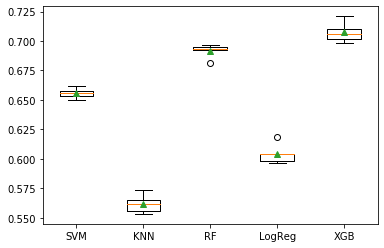

In [9]:
# define evaluation procedure
def evaluate_model(X, y, model):
    cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return scores


# define models to test
def get_models():
    models, names = list(), list()
    # SVM
    models.append(SVC(gamma='auto'))
    names.append('SVM')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    
    # RF
    models.append(RandomForestClassifier(n_estimators=500))
    names.append('RF')
    # ET
    #models.append(ExtraTreesClassifier(n_estimators=500))
    #names.append('ET')
    #LogisticRegression
    models.append(LogisticRegression(multi_class = 'ovr'))
    names.append('LogReg')
    #XGB
    models.append(xgb.XGBClassifier(objective='multi:softmax',n_estimators = 500))
    names.append('XGB')
    return models, names

# define models
models, names = get_models()
results = list()


# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### MODEL - 1 - RANDOM FOREST CLASSIFIER

Even though XGBoost shows higher accuracy than other models we are going to choose randomforest to try  as our final modeling because XGBoost is computationally so expensive.

In [8]:
#RandomForestClassifier 

from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=500,random_state = 1,n_jobs=-1)
model_res = model_rf.fit(X_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(model_rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = model_res.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_rf.score(X_train,y_train))
print("test accuracy: ", model_rf.score(X_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

train accuracy:  1.0
test accuracy:  0.6925200803212851
Random Forest: Accuracy=0.693
Random Forest: f1-score=0.666
                                                          precision    recall  f1-score   support

                                                   ARSON       0.00      0.00      0.00         7
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00         3
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.70      0.81      0.75       176
                                       ATTEMPTED ROBBERY       1.00      0.04      0.08        23
                                BATTERY - SIMPLE ASSAULT       0.69      0.89      0.78       361
                                 BATTERY POLICE (SIMPLE)       1.00      0.44      0.62         9
                             BATTERY WITH SEXUAL CONTACT       0.87      0.59      0.70        22
                                           BIKE - STOLEN       0.71      0.37      0.49        27
 

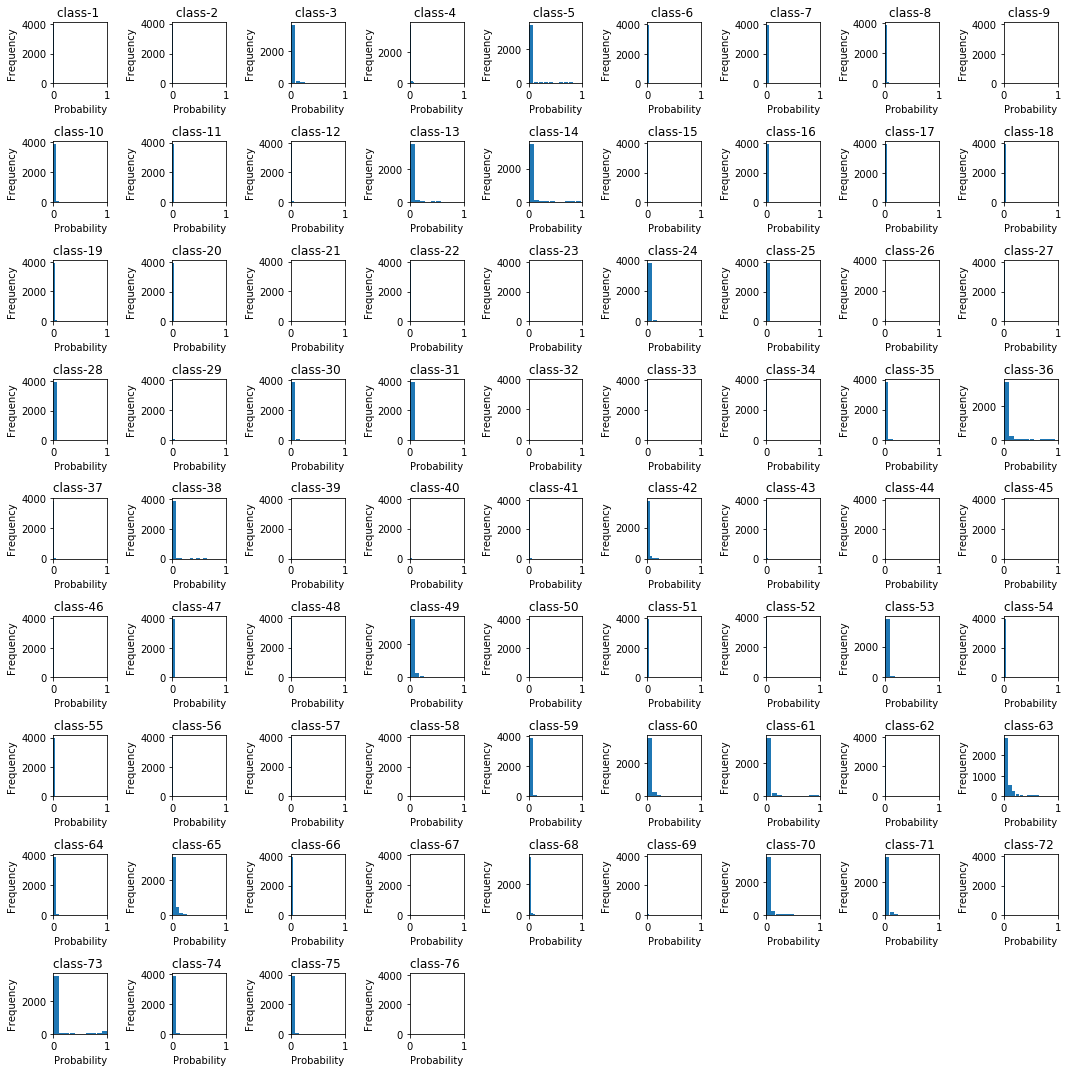

In [14]:
# histogram of predicted probabilitiesplt.figure(figsize=(12, 4))
y_pred_prob = model_res.predict_proba(X_test)
nclasses = len(np.unique(y_train))
plt.figure(figsize=(15, 15))
for i in range(nclasses):
    
    plt.subplot(9, 9, i+1)
    plt.hist(y_pred_prob[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('class-{} '.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Probability Density Plot for RF Classifier')

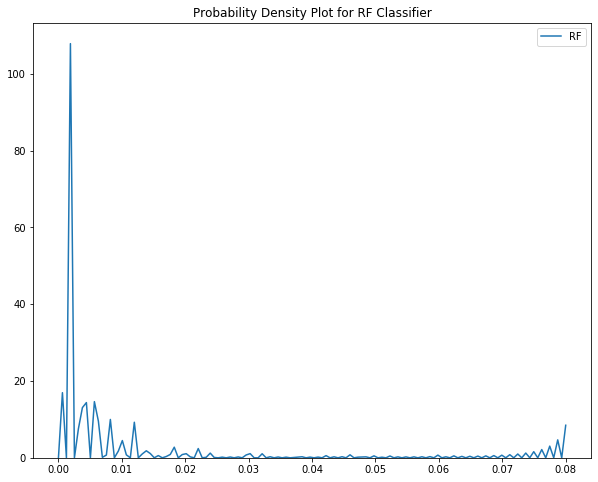

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.kdeplot(y_pred_prob[:,1],label="RF")

plt.title("Probability Density Plot for RF Classifier")

Because our dataset is severly imbalance we are going to trying other imbalanced methods.There are four types of imbalanced classification techniques to spot check:

    Data Sampling Algorithms
    Cost-Sensitive Algorithms
    One-Class Algorithms
    Probability Tuning Algorithms

Here we are going to try the first two methos.

### Cost-Sensitive Algorithms


Cost-sensitive algorithms are modified versions of machine learning algorithms designed to take the differing costs of misclassification into account when fitting the model on the training dataset.


### MODEL - 2

A cost-sensitive version of random forest with custom class weightings was found to achieve better performance.

#### CostSensitive Method

In [9]:
# Compute the costs
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))

#RandomForestClassifier with weights(COST-SENSITIVE METHOD)

from sklearn.ensemble import RandomForestClassifier
model_weights = RandomForestClassifier(n_estimators=500,class_weight = weights,random_state = 1,n_jobs=-1)
rf_weight = model_weights.fit(X_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(model_weights, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_weight.predict(X_test)
ac = accuracy_score(y_test, y_pred)
rf_weight_f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_weights.score(X_train,y_train))
print("test accuracy: ", model_weights.score(X_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



train accuracy:  1.0
test accuracy:  0.7053212851405622
Random Forest: Accuracy=0.705
Random Forest: f1-score=0.666
                                                          precision    recall  f1-score   support

                                                   ARSON       1.00      0.29      0.44         7
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00         3
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.70      0.80      0.74       176
                                       ATTEMPTED ROBBERY       1.00      0.04      0.08        23
                                BATTERY - SIMPLE ASSAULT       0.64      0.90      0.75       361
                                 BATTERY POLICE (SIMPLE)       1.00      0.44      0.62         9
                             BATTERY WITH SEXUAL CONTACT       0.81      0.59      0.68        22
                                           BIKE - STOLEN       0.89      0.63      0.74        27
 

#### Probability Density Plot

Text(0.5, 1.0, 'Probability Density Plot for RF Classifier')

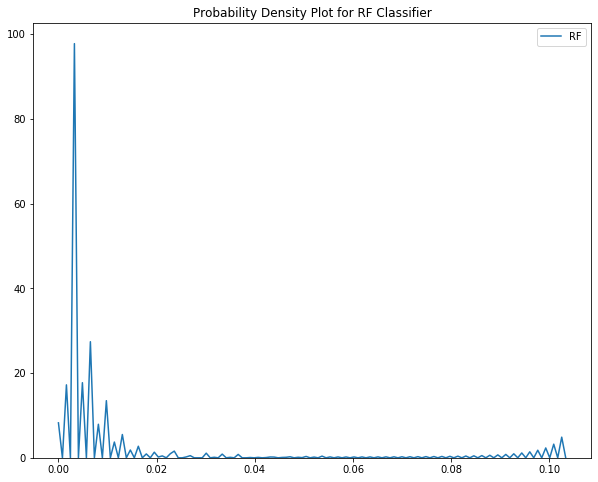

In [18]:
plt.figure(figsize=(10,8))
sns.kdeplot(model_res_weight.predict_proba(X_test)[:,1],label="RF")

plt.title("Probability Density Plot for RF Classifier")

### MODEL - 3

Class to perform over-sampling using SMOTE and cleaning using Tomek links.

Combine over- and under-sampling using SMOTE and Tomek links.

#### DATA SAMPLING METHOD

In [10]:
# Using SMOTETomek
from collections import Counter
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[('ARSON', 1441), ('ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER', 1441), ('ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 1436), ('ATTEMPTED ROBBERY', 1441), ('BATTERY - SIMPLE ASSAULT', 1405), ('BATTERY POLICE (SIMPLE)', 1441), ('BATTERY WITH SEXUAL CONTACT', 1441), ('BIKE - STOLEN', 1441), ('BOMB SCARE', 1441), ('BRANDISH WEAPON', 1441), ('BUNCO, GRAND THEFT', 1441), ('BUNCO, PETTY THEFT', 1441), ('BURGLARY', 1413), ('BURGLARY FROM VEHICLE', 1408), ('BURGLARY FROM VEHICLE, ATTEMPTED', 1441), ('BURGLARY, ATTEMPTED', 1441), ('CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT', 1441), ('CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT', 1441), ('CHILD ANNOYING (17YRS & UNDER)', 1441), ('CHILD NEGLECT (SEE 300 W.I.C.)', 1441), ('CHILD STEALING', 1441), ('CONTEMPT OF COURT', 1441), ('CRIMINAL HOMICIDE', 1441), ('CRIMINAL THREATS - NO WEAPON DISPLAYED', 1440), ('CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)', 1441), ('CRUELTY TO ANIMALS', 1441), ('DEFRAUDING INNKEEPER/THEFT OF SERVICES, $40

Now we are going to build a model with the SMOTE sampling data using RandomForest

In [11]:
#RandomForestClassifier 

from sklearn.ensemble import RandomForestClassifier
rf_smote = RandomForestClassifier(n_estimators=500,random_state = 1,n_jobs=-1)
rf_smote_res = rf_smote.fit(X_resampled, y_resampled)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(rf_smote_res, X_resampled, y_resampled, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_smote_res.predict(X_test)
y_pred_prob = rf_smote_res.predict_proba(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",rf_smote.score(X_resampled, y_resampled))
print("test accuracy: ", rf_smote.score(X_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


train accuracy:  1.0
test accuracy:  0.7206325301204819
Random Forest: Accuracy=0.721
Random Forest: f1-score=0.708
                                                          precision    recall  f1-score   support

                                                   ARSON       0.62      0.71      0.67         7
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00         3
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.69      0.87      0.77       176
                                       ATTEMPTED ROBBERY       0.65      0.48      0.55        23
                                BATTERY - SIMPLE ASSAULT       0.74      0.87      0.80       361
                                 BATTERY POLICE (SIMPLE)       0.75      0.67      0.71         9
                             BATTERY WITH SEXUAL CONTACT       0.79      0.68      0.73        22
                                           BIKE - STOLEN       0.58      0.78      0.67        27
 

#### Probability Density Plot

Text(0.5, 1.0, 'Probability Density Plot for RF Classifier')

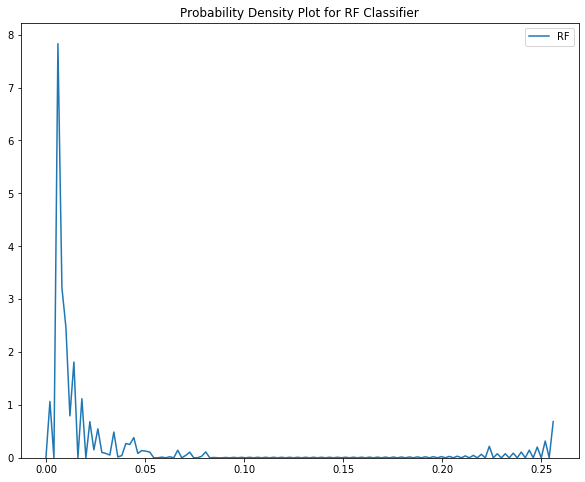

In [21]:
plt.figure(figsize=(10,8))
sns.kdeplot(rf_smote_res.predict_proba(X_test)[:,1],label="RF")

plt.title("Probability Density Plot for RF Classifier")

Now our model performs better using upsampling and downsampling data.But lets try another method for better more performance.


Now we are going to try classification with clustering.There are so many clustering methods but we are going to use DBSCAN because it also removes outliers(anamoly detection).


### MODEL - 4

### Classification with DBSCAN clustering

#### Anomaly detection and clustering:

DBSCAN is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.And it is also useful for outlier detection.



#### PCA

Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 61 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.


In [15]:
x_values = df.drop(['crm_cd_desc'],axis = 1).values
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca.fit(x_values)
pca_features = pca.transform(x_values)
print(pca_features.shape)


(19918, 2)


In [16]:
df_pca = pd.DataFrame(pca_features,columns = ['x','y'])

In [17]:
df_pca['crm_cd_desc'] = df.crm_cd_desc
df_pca

x          y                               crm_cd_desc
0      189.784634 -33.860622                                     ARSON
1      190.518050 -34.691525                                     ARSON
2      189.771423 -31.665540                                     ARSON
3      189.885417 -34.951227                                     ARSON
4      439.910318 -57.090459                                     ARSON
...           ...        ...                                       ...
19913  413.518312 -54.784082  VIOLATION OF TEMPORARY RESTRAINING ORDER
19914  190.517633 -33.986932  VIOLATION OF TEMPORARY RESTRAINING ORDER
19915  190.529075 -35.296822  VIOLATION OF TEMPORARY RESTRAINING ORDER
19916  190.950705 -34.214564  VIOLATION OF TEMPORARY RESTRAINING ORDER
19917  190.183923 -35.338071  VIOLATION OF TEMPORARY RESTRAINING ORDER

[19918 rows x 3 columns]

In [18]:
x_values = df_pca.drop(['crm_cd_desc'],axis = 1).values

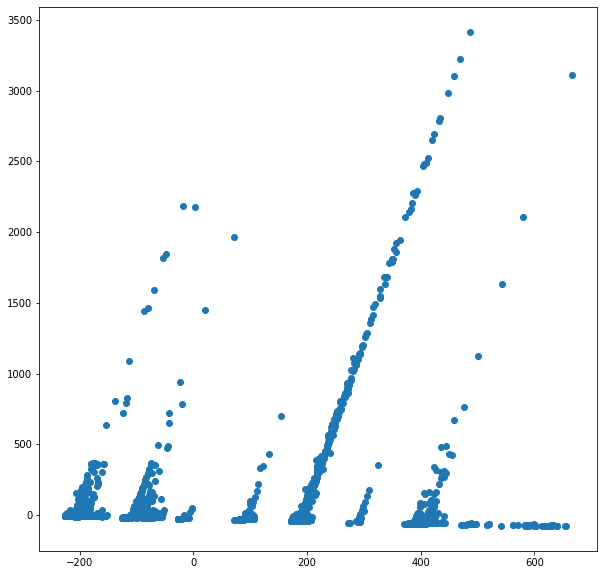

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(x_values[:,0], x_values[:,1])
plt.show()


In [20]:
#Finding the optimum epsilon using Nearest Neighbor
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(x_values)
distances,indices = nbrs.kneighbors(x_values)

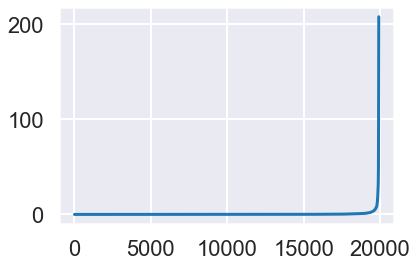

In [21]:
# Setup Seaborn
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

distances = np.sort(distances,axis = 0)
distances = distances[:,1]
plt.plot(distances)

In [19]:
#Choosing the best epsilon value
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
epsilon = [5,8,10,12]
silhouette_avg_scores = [] 
for i in epsilon:
    model = DBSCAN(eps=i)
    cluster_labels = model.fit_predict(x_values)
    silhouette_avg = silhouette_score(x_values, cluster_labels,random_state = 10)
    silhouette_avg_scores.append(silhouette_avg)
    print("For epsilon =", i,
          "The average silhouette_score is :", silhouette_avg)

For epsilon = 5 The average silhouette_score is : 0.720264845955237
For epsilon = 8 The average silhouette_score is : 0.7910327200187908
For epsilon = 10 The average silhouette_score is : 0.8100609936085608
For epsilon = 12 The average silhouette_score is : 0.8102027281483457


In [20]:
#Choosing the best min_sample
samples = range(1,20)
for i in samples:
    model = DBSCAN(eps=10,min_samples = i)
    cluster_labels = model.fit_predict(x_values)
    silhouette_avg = silhouette_score(x_values, cluster_labels,random_state = 10)
    silhouette_avg_scores.append(silhouette_avg)
    print("For min_sample = ", i,
          "The average silhouette_score is :", silhouette_avg)

For min_sample =  1 The average silhouette_score is : 0.5599726492913432
For min_sample =  2 The average silhouette_score is : 0.7781477936099652
For min_sample =  3 The average silhouette_score is : 0.7992406285777829
For min_sample =  4 The average silhouette_score is : 0.8104166945094332
For min_sample =  5 The average silhouette_score is : 0.8100609936085608
For min_sample =  6 The average silhouette_score is : 0.8087632062808747
For min_sample =  7 The average silhouette_score is : 0.8091073226631251
For min_sample =  8 The average silhouette_score is : 0.8066483861219614
For min_sample =  9 The average silhouette_score is : 0.8087010665577709
For min_sample =  10 The average silhouette_score is : 0.7706033567187809
For min_sample =  11 The average silhouette_score is : 0.8087257798668325
For min_sample =  12 The average silhouette_score is : 0.808151560679065
For min_sample =  13 The average silhouette_score is : 0.8063971205088172
For min_sample =  14 The average silhouette_scor

In [22]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 10, min_samples = 17)
print(dbscan)

DBSCAN(eps=10, min_samples=17)


In [23]:
df_pca['dbscan']= dbscan.fit_predict(x_values)

<Figure size 720x720 with 0 Axes>

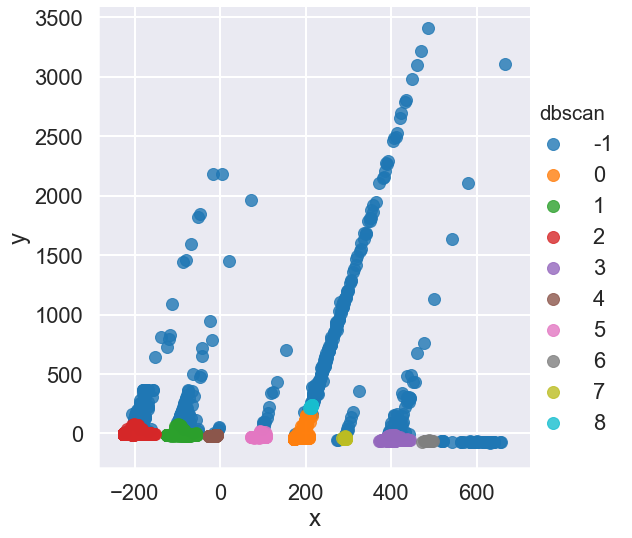

In [24]:
plt.figure(figsize=(10,10))
#plt.scatter(x[:,0], x[:,1],s = 2)
#plt.scatter(values[:,0], values[:,1], color='g',s = 4)
sns.lmplot(data = df_pca,x ='x',y='y',hue = 'dbscan',fit_reg=False,height  =8)
plt.show()

In [24]:
sample_df = df.copy()

In [25]:
sample_df['dbscan'] = df_pca['dbscan']

In [26]:
#remove the outliers
sample_df[~ sample_df.dbscan == -1]

area_name_0  area_name_1  area_name_2  area_name_3  area_name_4  \
0                0            0            0            0            0   
1                0            0            0            0            0   
2                0            0            0            0            0   
3                0            0            0            0            1   
6                0            0            0            1            0   
...            ...          ...          ...          ...          ...   
19911            0            0            1            1            0   
19914            0            1            0            0            1   
19915            0            1            0            1            0   
19916            0            1            0            1            0   
19917            0            1            0            1            0   

       area_name_5                               crm_cd_desc  vict_age  \
0                1                                     ARSON        48   
1                1                                     ARSON        35   
2                1                                     ARSON        37   
3                0                                     ARSON         0   
6                0                                     ARSON        76   
...            ...                                       ...       ...   
19911            0  VIOLATION OF TEMPORARY RESTRAINING ORDER        36   
19914            0  VIOLATION OF TEMPORARY RESTRAINING ORDER        35   
19915            0  VIOLATION OF TEMPORARY RESTRAINING ORDER        43   
19916            0  VIOLATION OF TEMPORARY RESTRAINING ORDER        64   
19917            0  VIOLATION OF TEMPORARY RESTRAINING ORDER        25   

       vict_sex_0  vict_sex_1  ...  location_14      lat       lon  \
0               0           0  ...            1  33.9773 -118.2892   
1               0           0  ...            0  33.9678 -118.2871   
2               0           1  ...            1  33.9647 -118.2608   
3               0           0  ...            0  34.0423 -118.2631   
6               0           1  ...            1  34.2139 -118.3818   
...           ...         ...  ...          ...      ...       ...   
19911           0           1  ...            0  34.0581 -118.3066   
19914           0           1  ...            0  34.1867 -118.4325   
19915           0           0  ...            0  34.1976 -118.4837   
19916           0           0  ...            0  34.1867 -118.4793   
19917           0           1  ...            1  34.1775 -118.5338   

       day_crime_occ  no_rptd_occ  Hour  Minutes  month_crime_occ  \
0                  4            1     1       17                2   
1                  6            0     6        0                5   
2                  1            3    23        0                6   
3                  4            0     6       30                3   
6                  1            7     4       42                5   
...              ...          ...   ...      ...              ...   
19911              4            0    17       15               12   
19914              0            1    18       20                3   
19915              5            0     4       45                7   
19916              4            1    17       30                5   
19917              4            0    21       50                5   

       year_crime_occ  dbscan  
0                2015       0  
1                2011       0  
2                2010       0  
3                2019       0  
6                2018       0  
...               ...     ...  
19911            2017       0  
19914            2019       0  
19915            2015       0  
19916            2013       0  
19917            2019       0  

[6673 rows x 62 columns]

In [27]:
# Split the data 
from sklearn.model_selection import train_test_split
X = sample_df.drop(['crm_cd_desc'],axis= 1)
y = sample_df.crm_cd_desc

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y, test_size=.2, random_state=123,stratify = y)

In [28]:
#Scale the data
from sklearn.preprocessing import StandardScaler
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = StandardScaler().fit(Xc_train)
Xc_train=scaler.transform(Xc_train)
Xc_test=scaler.transform(Xc_test)

In [29]:
#RandomForestClassifier 

from sklearn.ensemble import RandomForestClassifier
rf_cluster = RandomForestClassifier(n_estimators=500,random_state = 1,n_jobs=-1)
rf_cluster_res = rf_cluster.fit(Xc_train, yc_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(rf_cluster, Xc_train, yc_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_cluster_res.predict(Xc_test)
ac = accuracy_score(yc_test, y_pred)
f1 = f1_score(yc_test, y_pred, average='weighted')
cm = confusion_matrix(yc_test, y_pred)
print("train accuracy: ",rf_cluster_res.score(Xc_train,yc_train))
print("test accuracy: ", rf_cluster_res.score(Xc_test,yc_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(yc_test, y_pred))
print(confusion_matrix(yc_test, y_pred))


train accuracy:  1.0
test accuracy:  0.6890060240963856
Random Forest: Accuracy=0.689
Random Forest: f1-score=0.663
                                                          precision    recall  f1-score   support

                                                   ARSON       0.00      0.00      0.00         7
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00         3
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.68      0.80      0.73       176
                                       ATTEMPTED ROBBERY       1.00      0.04      0.08        23
                                BATTERY - SIMPLE ASSAULT       0.69      0.89      0.78       361
                                 BATTERY POLICE (SIMPLE)       1.00      0.44      0.62         9
                             BATTERY WITH SEXUAL CONTACT       0.86      0.55      0.67        22
                                           BIKE - STOLEN       0.82      0.33      0.47        27
 

In [30]:
# Compute the costs
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(yc_train),yc_train)
weights = dict(zip(np.unique(yc_train),class_weight))

#RandomForestClassifier with weights(COST-SENSITIVE METHOD)

from sklearn.ensemble import RandomForestClassifier
rf_cluster_weight = RandomForestClassifier(n_estimators=500,class_weight = weights,random_state = 1,n_jobs=-1)
rf_cluster_weight_res = rf_cluster_weight.fit(Xc_train, yc_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(rf_cluster, Xc_train, yc_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_cluster_res.predict(Xc_test)
ac = accuracy_score(yc_test, y_pred)
f1 = f1_score(yc_test, y_pred, average='weighted')
cm = confusion_matrix(yc_test, y_pred)
print("train accuracy: ",rf_cluster_res.score(Xc_train,yc_train))
print("test accuracy: ", rf_cluster_res.score(Xc_test,yc_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(yc_test, y_pred))
print(confusion_matrix(yc_test, y_pred))


train accuracy:  1.0
test accuracy:  0.6890060240963856
Random Forest: Accuracy=0.689
Random Forest: f1-score=0.663
                                                          precision    recall  f1-score   support

                                                   ARSON       0.00      0.00      0.00         7
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00         3
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.68      0.80      0.73       176
                                       ATTEMPTED ROBBERY       1.00      0.04      0.08        23
                                BATTERY - SIMPLE ASSAULT       0.69      0.89      0.78       361
                                 BATTERY POLICE (SIMPLE)       1.00      0.44      0.62         9
                             BATTERY WITH SEXUAL CONTACT       0.86      0.55      0.67        22
                                           BIKE - STOLEN       0.82      0.33      0.47        27
 

### SMOTETomek

In [31]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
Xc_resampled, yc_resampled = smote_tomek.fit_resample(Xc_train, yc_train)
print(sorted(Counter(yc_resampled).items()))

[('ARSON', 1441), ('ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER', 1441), ('ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 1431), ('ATTEMPTED ROBBERY', 1441), ('BATTERY - SIMPLE ASSAULT', 1396), ('BATTERY POLICE (SIMPLE)', 1441), ('BATTERY WITH SEXUAL CONTACT', 1441), ('BIKE - STOLEN', 1441), ('BOMB SCARE', 1441), ('BRANDISH WEAPON', 1441), ('BUNCO, GRAND THEFT', 1441), ('BUNCO, PETTY THEFT', 1441), ('BURGLARY', 1418), ('BURGLARY FROM VEHICLE', 1410), ('BURGLARY FROM VEHICLE, ATTEMPTED', 1441), ('BURGLARY, ATTEMPTED', 1441), ('CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT', 1441), ('CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT', 1441), ('CHILD ANNOYING (17YRS & UNDER)', 1441), ('CHILD NEGLECT (SEE 300 W.I.C.)', 1441), ('CHILD STEALING', 1441), ('CONTEMPT OF COURT', 1441), ('CRIMINAL HOMICIDE', 1441), ('CRIMINAL THREATS - NO WEAPON DISPLAYED', 1441), ('CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)', 1441), ('CRUELTY TO ANIMALS', 1441), ('DEFRAUDING INNKEEPER/THEFT OF SERVICES, $40

In [33]:
#RandomForestClassifier 

from sklearn.ensemble import RandomForestClassifier
rf_cluster_smote = RandomForestClassifier(n_estimators=500)
rf_cluster_smote_res = rf_cluster_smote.fit(Xc_resampled, yc_resampled)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(rf_cluster_smote, Xc_resampled, yc_resampled, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_cluster_smote_res.predict(Xc_test)
ac = accuracy_score(yc_test, y_pred)
f1 = f1_score(yc_test, y_pred, average='micro')
cm = confusion_matrix(yc_test, y_pred)
print("train accuracy: ",rf_cluster_smote.score(Xc_resampled, yc_resampled))
print("test accuracy: ", rf_cluster_smote.score(Xc_test,yc_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(yc_test, y_pred))
print(confusion_matrix(yc_test, y_pred))


train accuracy:  1.0
test accuracy:  0.7161144578313253
Random Forest: Accuracy=0.716
Random Forest: f1-score=0.716
                                                          precision    recall  f1-score   support

                                                   ARSON       0.71      0.71      0.71         7
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00         3
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.67      0.86      0.75       176
                                       ATTEMPTED ROBBERY       0.65      0.48      0.55        23
                                BATTERY - SIMPLE ASSAULT       0.74      0.86      0.79       361
                                 BATTERY POLICE (SIMPLE)       0.75      0.67      0.71         9
                             BATTERY WITH SEXUAL CONTACT       0.70      0.64      0.67        22
                                           BIKE - STOLEN       0.60      0.78      0.68        27
 

#### Choosing best model

In [9]:
from sklearn.metrics import recall_score,precision_score,f1_score

In [35]:
modelCompare = pd.DataFrame({'Data':['Without Cluster','Without Cluster','Without Cluster',
                                    'With Cluster','With Cluster','With Cluster'],
                             'Model':['Random Forest', 'CostSenstivity', 'SMOTETomek',
                                     'Random Forest', 'CostSenstivity', 'SMOTETomek'], 
                             'f1_score(weighted)': [f1_score(y_test,model_res.predict(X_test),average='weighted'),
                                                    f1_score(y_test,rf_weight.predict(X_test),average='weighted'),
                                                    f1_score(y_test,rf_smote_res.predict(X_test),average='weighted'),
                                                   f1_score(yc_test,rf_cluster_res.predict(Xc_test),average='weighted'),
                                                    f1_score(yc_test,rf_cluster_weight_res.predict(Xc_test),average='weighted'),
                                                    f1_score(yc_test,rf_cluster_smote_res.predict(Xc_test),average='weighted')],
                             'Precision': [precision_score(y_test,model_res.predict(X_test),average='weighted'),
                                           precision_score(y_test,rf_weight.predict(X_test),average='weighted'),
                                           precision_score(y_test,rf_smote_res.predict(X_test),average='weighted'),
                                          precision_score(yc_test,rf_cluster_res.predict(Xc_test),average='weighted'),
                                           precision_score(yc_test,rf_cluster_weight_res.predict(Xc_test),average='weighted'),
                                           precision_score(yc_test,rf_cluster_smote_res.predict(Xc_test),average='weighted')],
                             'Recall': [recall_score(y_test,model_res.predict(X_test),average='weighted'),
                                        recall_score(y_test,rf_weight.predict(X_test),average='weighted'),
                                        recall_score(y_test,rf_smote_res.predict(X_test),average='weighted'),
                                       recall_score(yc_test,rf_cluster_res.predict(Xc_test),average='weighted'),
                                        recall_score(yc_test,rf_cluster_weight_res.predict(Xc_test),average='weighted'),
                                        recall_score(yc_test,rf_cluster_smote_res.predict(Xc_test),average='weighted')],
                             'Training Accuracy':[model_res.score(X_train,y_train),
                                                  rf_weight.score(X_train,y_train),
                                                 rf_smote_res.score(X_train,y_train),
                                                 rf_cluster_res.score(Xc_train,yc_train),
                                                  rf_cluster_weight_res.score(Xc_train,yc_train),
                                                 rf_cluster_smote_res.score(Xc_train,yc_train)],
                            'Testing Acuuracy':[model_res.score(X_test,y_test),
                                                rf_weight.score(X_test,y_test),
                                                rf_smote_res.score(X_test,y_test),
                                               rf_cluster_res.score(Xc_test,yc_test),
                                                rf_cluster_weight_res.score(Xc_test,yc_test),
                                                rf_cluster_smote_res.score(Xc_test,yc_test)]})

modelCompare

Data           Model  f1_score(weighted)  Precision    Recall  \
0  Without Cluster   Random Forest            0.665862   0.687547  0.692520   
1  Without Cluster  CostSenstivity            0.684097   0.712974  0.705321   
2  Without Cluster      SMOTETomek            0.708039   0.719709  0.720633   
3     With Cluster   Random Forest            0.662955   0.681588  0.689006   
4     With Cluster  CostSenstivity            0.678772   0.705273  0.701556   
5     With Cluster      SMOTETomek            0.703126   0.713977  0.716114   

   Training Accuracy  Testing Acuuracy  
0           1.000000          0.692520  
1           1.000000          0.705321  
2           0.992281          0.720633  
3           1.000000          0.689006  
4           1.000000          0.701556  
5           0.992155          0.716114

In [ ]:
modelCompare.to_csv('Model_Comparision.csv',index = False)

In [8]:
Evaluating_models = pd.DataFrame({'Model': ['SVM','KNN','RF','LogReg','XGB'],
              'Acuuracy(mean)':[0.656,0.562,0.692,0.604,0.708],
              'Acuuracy(std)' : [0.004,0.007,0.005,0.008,0.008]})
Evaluating_models.to_csv('Evaluating_models.csv',index = False)                

In [9]:
Evaluating_models

Model  Acuuracy(mean)  Acuuracy(std)
0     SVM           0.656          0.004
1     KNN           0.562          0.007
2      RF           0.692          0.005
3  LogReg           0.604          0.008
4     XGB           0.708          0.008

In [11]:
model_compare = pd.DataFrame({'Model':['Without Cluster','Without Cluster','Without Cluster',
                                    'With Cluster','With Cluster','With Cluster'],
                             'Algorithm':['Random Forest', 'CostSenstivity', 'SMOTETomek',
                                     'Random Forest', 'CostSenstivity', 'SMOTETomek'], 
                             'f1_score(weighted)': [0.665862,0.684097,0.708039,0.662955,0.678772,0.703126],
                             'Precision': [0.687547,0.712974,0.719709,0.681588,0.705273,0.713977],
                             'Recall': [0.692520,0.705321,0.720633,0.689006,0.701556,0.716114],
                             'Training Accuracy':[1.000000,1.000000,0.992281,1.000000,1.000000,0.992155],
                            'Testing Acuuracy':[0.692520,0.705321,0.720633,0.689006,0.701556,0.716114]})
model_compare

Model       Algorithm  f1_score(weighted)  Precision    Recall  \
0  Without Cluster   Random Forest            0.665862   0.687547  0.692520   
1  Without Cluster  CostSenstivity            0.684097   0.712974  0.705321   
2  Without Cluster      SMOTETomek            0.708039   0.719709  0.720633   
3     With Cluster   Random Forest            0.662955   0.681588  0.689006   
4     With Cluster  CostSenstivity            0.678772   0.705273  0.701556   
5     With Cluster      SMOTETomek            0.703126   0.713977  0.716114   

   Training Accuracy  Testing Acuuracy  
0           1.000000          0.692520  
1           1.000000          0.705321  
2           0.992281          0.720633  
3           1.000000          0.689006  
4           1.000000          0.701556  
5           0.992155          0.716114

In [12]:
model_compare.to_csv('Model_Comparision.csv',index = False)

From the above table,we could find the best model as SMOTETomek(without cluster) but it is computationally so 

expensive.So we are going to choose the next best model CostSensitivity(without cluster) method as the final 

model.

Now lets do some hyperparameter tunning for best parameters to improve the performance of our model.

### HYPER PARAMETER TUNING

In [10]:
#Randomised cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report, recall_score, precision_recall_curve

# Compute the costs
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))

#RandomForestClassifier with weights(COST-SENSITIVE METHOD)


cross_val = StratifiedKFold(n_splits=5,shuffle=True, random_state = 1)
#index_iterator = cross_val.split(X_train, y_train)
params = {'max_depth': [20,25,30,35], 
          'min_samples_split': [4,6,8,10],
          'min_samples_leaf' : [2,4,8,16],
          'n_estimators' : [400,600,800],
          'max_features':[0.5,0.7,'sqrt','auto']
             }
scoring = {'Recall': make_scorer(recall_score,average = 'weighted'),
           'f1_score': make_scorer(f1_score,average = 'weighted'),
           'precision': make_scorer(precision_score,average = 'weighted'),
           'Accuracy': make_scorer(accuracy_score)
          }
clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = params, n_iter =100, cv = cross_val,
                            verbose=2, random_state =1, n_jobs = -1,scoring=scoring,refit='Accuracy')
clf_random.fit(X_train, y_train)




Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 49.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [20, 25, 30, 35],
                                        'max_features': [0.5, 0.7, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [2, 4, 8, 16],
                                        'min_samples_split': [4, 6, 8, 10],
                                        'n_estimators': [400, 600, 800]},
                   random_state=1, refit='Accuracy',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'Recall': make_scorer(recall_score, average=weighted),
                            'f1_score': make_scorer(f1_score, average=weighted),
                            'precision': make_scorer(precision_score, average=weighted)},
                   verbose=2

In [12]:
print(clf_random.best_params_)

{'n_estimators': 800, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30}


In [13]:
print(clf_random.best_score_)

0.7246139221819022


### Final Model

In [64]:
%%time
# Compute the costs
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))

#RandomForestClassifier with weights(COST-SENSITIVE METHOD)

from sklearn.ensemble import RandomForestClassifier
model_weights = RandomForestClassifier(n_estimators = 800, min_samples_split = 6, min_samples_leaf = 2, 
                                       max_features = 0.5, max_depth = 30,
                                       class_weight = weights,random_state = 1,n_jobs=-1)
rf_weight = model_weights.fit(X_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(model_weights, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_weight.predict(X_test)
ac = accuracy_score(y_test, y_pred)
rf_weight_f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_weights.score(X_train,y_train))
print("test accuracy: ", model_weights.score(X_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (rf_weight_f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


train accuracy:  0.9564453370151876
test accuracy:  0.7156124497991968
Random Forest: Accuracy=0.716
Random Forest: f1-score=0.706
                                                          precision    recall  f1-score   support

                                                   ARSON       0.62      0.71      0.67         7
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00         3
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.71      0.84      0.77       176
                                       ATTEMPTED ROBBERY       0.56      0.43      0.49        23
                                BATTERY - SIMPLE ASSAULT       0.75      0.86      0.80       361
                                 BATTERY POLICE (SIMPLE)       0.33      0.56      0.42         9
                             BATTERY WITH SEXUAL CONTACT       0.71      0.68      0.70        22
                                           BIKE - STOLEN       0.42      0.74      0

In [255]:

print("Train accuracy: ",rf_weight.score(X_train,y_train))
print("Test accuracy: ", rf_weight.score(X_test,y_test))

print('Random Forest: (weighted) f1-score=%.3f' % (rf_weight_f1))
print('                          Precision=%.3f' % (precision_score(y_test,rf_weight.predict(X_test),average='weighted')))
print('                          Recall=%.3f' % (recall_score(y_test,rf_weight.predict(X_test),average='weighted')))


Train accuracy:  0.9564453370151876
Test accuracy:  0.7156124497991968
Random Forest: (weighted) f1-score=0.706
                          Precision=0.717
                          Recall=0.716


By tuning the hyper parameters we are able to increase the performance(f1-score) by 3%.

Before Hyperparameter tuning performance was 0.684 now it is 0.71.

In [13]:
best_model = pd.DataFrame({'Model':['Random Forest'], 
                            'Method' : ['Cost Sensitive'],
                            'Training_accuracy' : [0.956],
                            'Test_accuracy' : [0.715],
                             'f1_score(weighted)': [0.706],
                             'Precision': [0.717],
                             'recall': [0.716],
                             'Hyperparameters': ['n_estimators : 800, min_samples_split : 6, min_samples_leaf : 2, max_features : 0.5, max_depth : 30']})
best_model.to_csv('best_model_metrics.csv',index=False)
best_model

Model          Method  Training_accuracy  Test_accuracy  \
0  Random Forest  Cost Sensitive              0.956          0.715   

   f1_score(weighted)  Precision  recall  \
0               0.706      0.717   0.716   

                                     Hyperparameters  
0  n_estimators : 800, min_samples_split : 6, min...

#### Probability Density Plot

In [24]:
prob = rf_weight.predict_proba(X_test)

Text(0.5, 1.0, 'Probability Density Plot for RF Classifier')

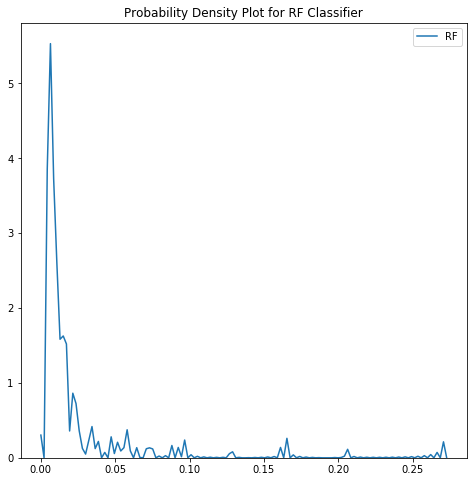

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8))
sns.kdeplot(prob[:,1],label="RF")

plt.title("Probability Density Plot for RF Classifier")

### Review the final model to determine important features

### Feature Reduction

From previous experience and the graphs produced at the beginning, we know that some features are not useful for our crime prediction problem. To reduce the number of features, which will reduce runtime, hopefully without significantly reducing performance, we will examine the feature importances from the random forest.

In [41]:
# Get numerical feature importances
importances = list(rf_weight.feature_importances_)
feature_list = list(X.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances[:20]]

Variable: vict_age Importance: 0.09
Variable: premis_cd Importance: 0.06
Variable: lat Importance: 0.06
Variable: location_4 Importance: 0.05
Variable: location_5 Importance: 0.05
Variable: lon Importance: 0.05
Variable: Hour Importance: 0.05
Variable: location_2 Importance: 0.04
Variable: location_3 Importance: 0.04
Variable: location_6 Importance: 0.04
Variable: location_7 Importance: 0.04
Variable: no_rptd_occ Importance: 0.04
Variable: month_crime_occ Importance: 0.04
Variable: year_crime_occ Importance: 0.04
Variable: weapon_used_cd Importance: 0.03
Variable: location_8 Importance: 0.03
Variable: Minutes Importance: 0.03
Variable: location_9 Importance: 0.02
Variable: day_crime_occ Importance: 0.02
Variable: area_name_1 Importance: 0.01


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Text(0.5, 1.0, 'Variable Importances')

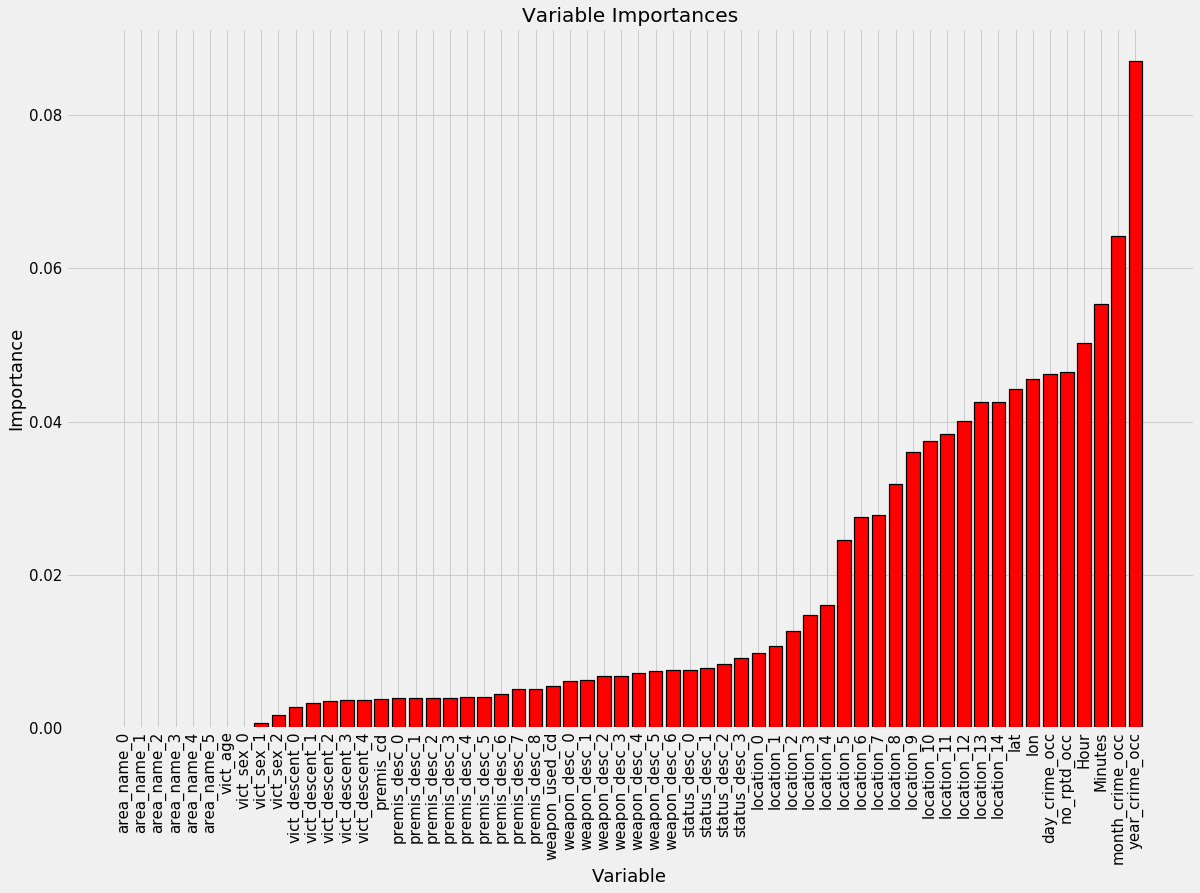

In [42]:
plt.rcParams['font.size'] = 15
plt.subplots(1,1,figsize=(18, 12))
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
#plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
plt.bar(x_values, feature_importance[sorted_idx], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

Text(0.5, 1.0, 'Cumulative Importances')

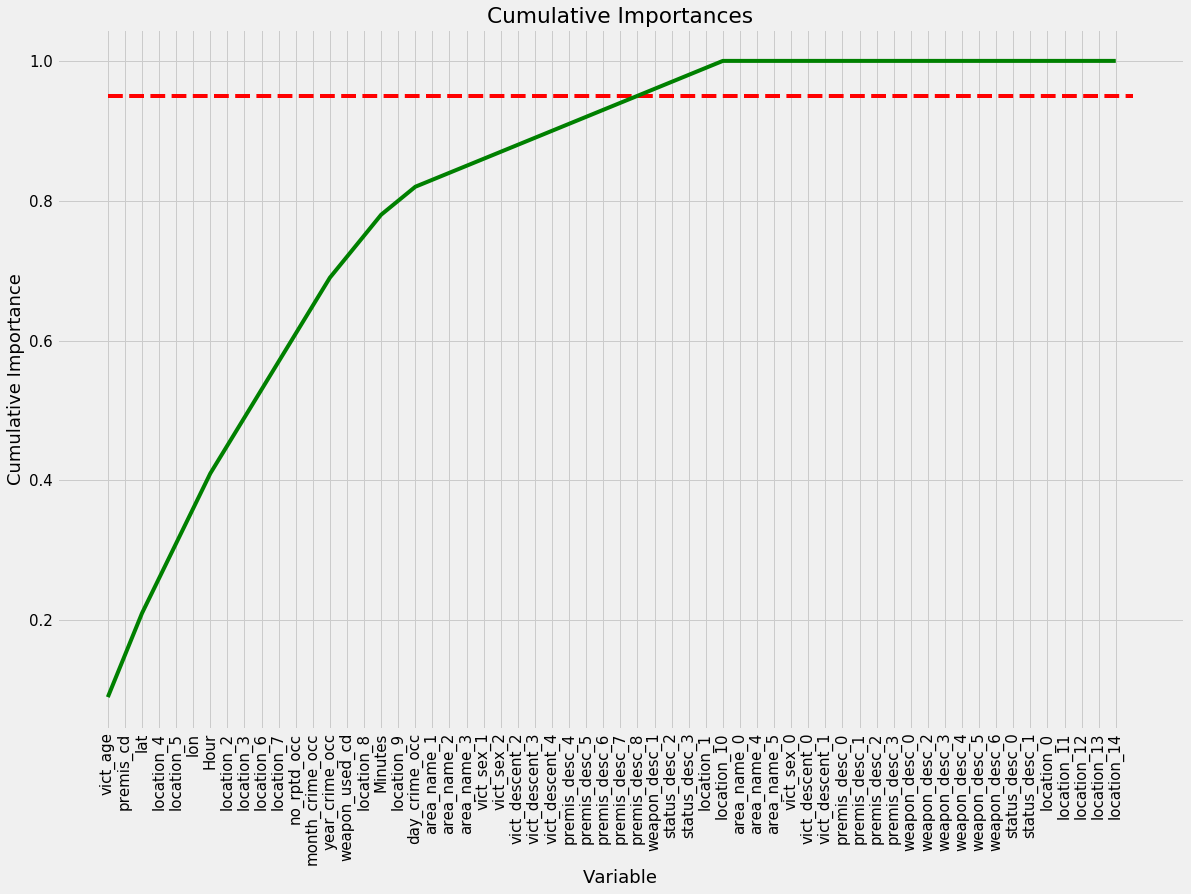

In [54]:
plt.rcParams['font.size'] = 15
plt.subplots(1,1,figsize=(18,12))
feature_importance = rf_weight.feature_importances_
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
x_values = list(range(len(list(rf_weight.feature_importances_))))

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance') 
plt.title('Cumulative Importances')


#### Limit Number of Features

We will now reduce the number of features in use by the model to only those required to account for 95% of the importance. The same number of features must be used in the training and testing sets.

In [55]:
#Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 32


In [61]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:32]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = X_train[:, important_indices]
important_test_features = X_test[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (15934, 32)
Important test features shape: (3984, 32)


### Training on Important Features

In [63]:
%%time
#RandomForestClassifier  
rf_imp = model_weights.fit(important_train_features, y_train)
y_pred_imp = rf_imp.predict(important_test_features)
y_pred_prob_imp = rf_imp.predict_proba(important_test_features)

print("Training accuracy:", rf_imp.score(important_train_features,y_train))
print("Test accuracy: ", rf_imp.score(important_test_features,y_test))



print('Random Forest: (weighted) f1-score=%.3f' % (f1_score(y_test,rf_imp.predict(important_test_features),average='weighted')))
print('                          Precision=%.3f' % (precision_score(y_test,rf_imp.predict(important_test_features),average='weighted')))
print('                          Recall=%.3f' % (recall_score(y_test,rf_imp.predict(important_test_features),average='weighted')))


#print(classification_report(y_test, y_pred_imp))
#print(confusion_matrix(y_test, y_pred_imp))

Training accuracy: 0.9454625329484122
Test accuracy:  0.6872489959839357
Random Forest: (weighted) f1-score=0.678
                          Precision=0.682
                          Recall=0.687
                                                          precision    recall  f1-score   support

                                                   ARSON       0.43      0.43      0.43         7
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.50      0.33      0.40         3
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.72      0.81      0.76       176
                                       ATTEMPTED ROBBERY       0.59      0.70      0.64        23
                                BATTERY - SIMPLE ASSAULT       0.75      0.85      0.79       361
                                 BATTERY POLICE (SIMPLE)       0.43      0.67      0.52         9
                             BATTERY WITH SEXUAL CONTACT       0.79      0.68      0.73        22
                    

Model with all the features:

    CPU times: user 2min 6s, sys: 7.04 s, total: 2min 13s
    Wall time: 1min 50s
    f1_score : 0.71


Model with all important features :

    CPU times: user 1min 58s, sys: 6.64 s, total: 2min 5s
    Wall time: 22.8 s
    f1_score: 0.68
    
    
It is evident that by reducing the features we are able to decrease the runtime but the accuracy also reduced.
So need to trade off between performance runtime and accuracy depends on the requiremets.

As of now we are considering the accuracy as important metric so we are going to take the model with all the features as our final model.

### AUC-ROC for Multi-Class Classification

The AUC-ROC curve is only for binary classification problems. But we can extend it to multiclass classification problems by using the One vs All technique.

So, if we have three classes 0, 1, and 2, the ROC for class 0 will be generated as classifying 0 against not 0, i.e. 1 and 2. The ROC for class 1 will be generated as classifying 1 against not 1, and so on.


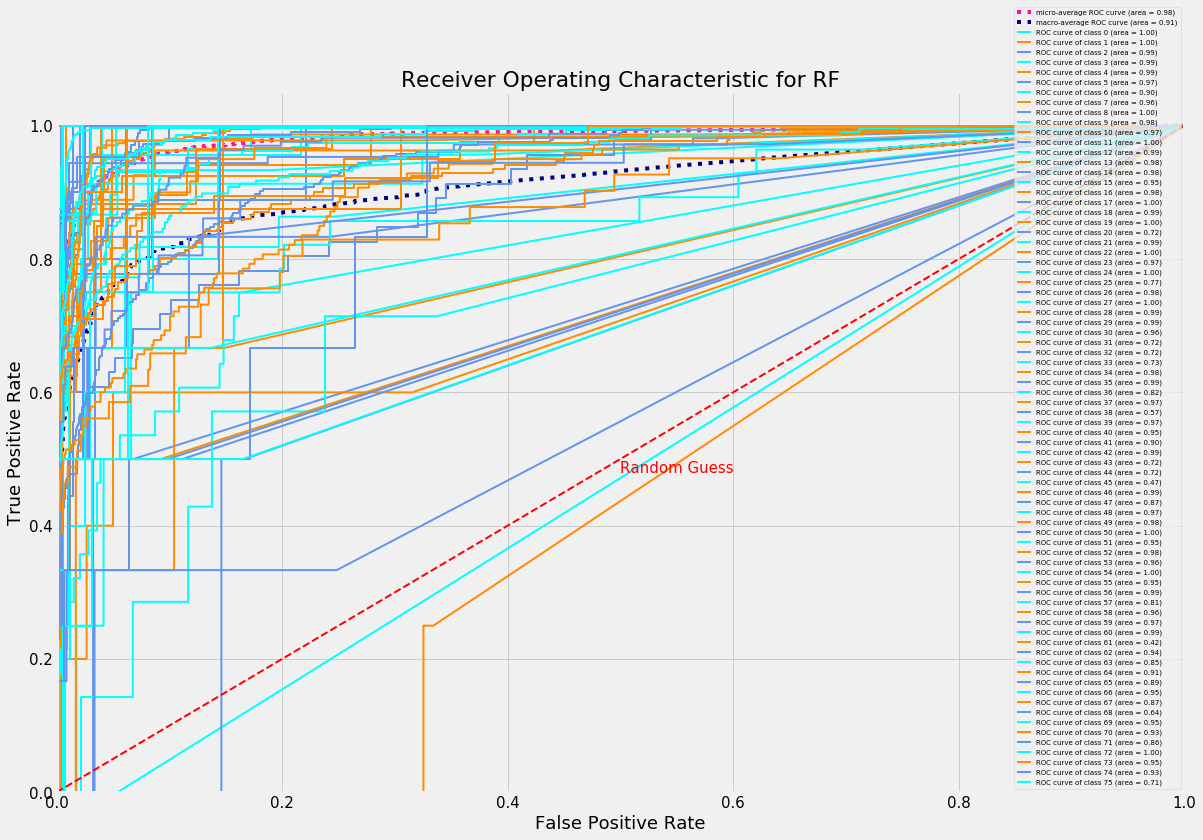

In [252]:
# multi-class classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import itertools



# Learn to predict each class against the other
rf = RandomForestClassifier(n_estimators = 800, min_samples_split = 6, min_samples_leaf = 2, 
                                       max_features = 0.5, max_depth = 30,
                                       class_weight = "balanced",random_state = 1,n_jobs=-1)
clf = OneVsRestClassifier(rf)
predprob = clf.fit(X_train, y_train).predict_proba(X_test)



# roc curve for classes


n_classes = len(np.unique(y_train))


### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], 
                                  predprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(y_test)).ravel(), predprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure(figsize=(18,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


#plt.subplots(1,1,figsize=(18,12))
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RF')
plt.legend(loc="lower right", prop={'size': 7})
#plot.legend(loc=2, prop={'size': 6})
plt.show()


In [254]:
#Area under ROC for the multiclass
prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.900901 (macro),
0.933799 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.911939 (macro),
0.965270 (weighted by prevalence)


Though we build a model (with accuracy performance 71%) to classify every single type of crime(including low frequency crimes), it is not really practical since some crimes are happening at extremely low frequency. Based on the sorted list of crimes, we can see that some crimes are really rare.

Since these rare records won’t greatly affect our model, we are not able to improve performance with every other possible models further.

Now we are going to pick the top 10 crimes and try to build a model for those High frequency crimes.

### Model for High Frequency Crimes

In [16]:
#load the data
crimes_high = pd.read_csv('/Users/HOME/Desktop/LosAngelesCrime/data/preprocess_output.csv',index_col = 0)
crimes_high.head()

area_name_0  area_name_1  area_name_2  area_name_3  area_name_4  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            1   
4            0            0            0            0            1   

   area_name_5  crm_cd crm_cd_desc  vict_age  vict_sex_0  ...  location_13  \
0            1     648       ARSON        48           0  ...            0   
1            1     648       ARSON        35           0  ...            1   
2            1     648       ARSON        37           0  ...            1   
3            0     648       ARSON         0           0  ...            0   
4            0     648       ARSON        16           0  ...            0   

   location_14      lat       lon  day_crime_occ  no_rptd_occ  Hour  Minutes  \
0            1  33.9773 -118.2892              4            1     1       17   
1            0  33.9678 -118.2871              6            0     6        0   
2            1  33.9647 -118.2608              1            3    23        0   
3            0  34.0423 -118.2631              4            0     6       30   
4            1  34.0515 -118.2424              3            0     9       30   

   month_crime_occ  year_crime_occ  
0                2            2015  
1                5            2011  
2                6            2010  
3                3            2019  
4                1            2017  

[5 rows x 62 columns]

In [17]:
crimes_high.shape

(19918, 62)

In [18]:
high_crimes = crimes_high.crm_cd_desc.value_counts().head(10).index

In [7]:
crimes_high = crimes_high[crimes_high.crm_cd_desc.isin(high_crimes)]

In [8]:
sample_dfo = crimes_high.select_dtypes(include=['object'])
sample_dfo.shape
#get levels for all variables
vn = pd.DataFrame(sample_dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

VarName  LevelsCount
0  crm_cd_desc           10

In [9]:
crimes_high.shape

(12719, 62)

In [10]:
crimes_high.drop(['crm_cd'],axis = 1,inplace = True)

In [11]:
# Split the data 
from sklearn.model_selection import train_test_split
X = crimes_high.drop(['crm_cd_desc'],axis= 1)
y = crimes_high.crm_cd_desc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123,stratify = y)

In [12]:
#Scale the data
from sklearn.preprocessing import StandardScaler
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

>SVM 0.817 (0.007)
>KNN 0.745 (0.003)
>RF 0.835 (0.006)
>LogReg 0.768 (0.009)
>XGB 0.854 (0.006)


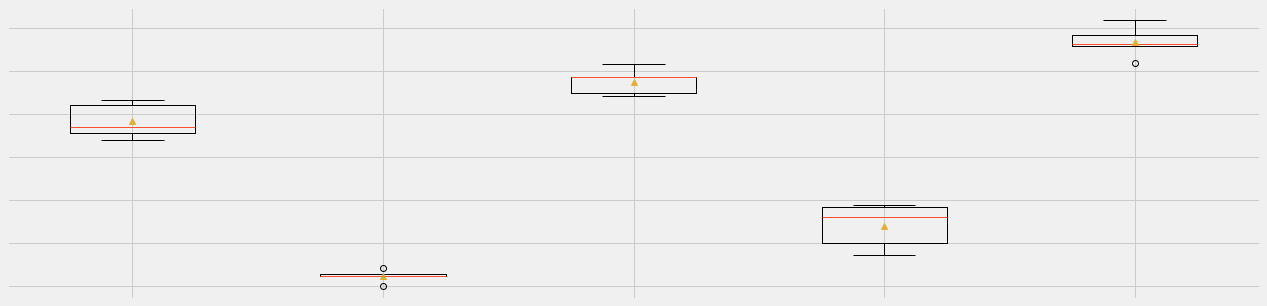

In [325]:

# define evaluation procedure
def evaluate_model(X, y, model):
    cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    
    return scores


# define models to test
def get_models():
    models, names = list(), list()
    # SVM
    models.append(SVC(gamma='auto'))
    names.append('SVM')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    # Bagging
    #models.append(BaggingClassifier(n_estimators=500,random_state = 123))
    #names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=500))
    names.append('RF')
    # ET
    #models.append(ExtraTreesClassifier(n_estimators=500))
    #names.append('ET')
    #LogisticRegression
    models.append(LogisticRegression(multi_class = 'ovr'))
    names.append('LogReg')
    #XGB
    models.append(xgb.XGBClassifier(objective='multi:softmax',n_estimators = 500))
    names.append('XGB')
    return models, names

# define models
models, names = get_models()
results = list()


# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    
# plot the results
plt.figure(figsize=(20,5))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [14]:
# Evaluating models 
Evaluating_models = pd.DataFrame({'Model': ['SVM','KNN','RF','LogReg','XGB'],
              'Acuuracy(mean)':[0.656,0.562,0.692,0.604,0.708],
              'Acuuracy(std)' : [0.004,0.007,0.005,0.008,0.008]})
Evaluating_models.to_csv('Evaluating_models.csv',index = False)    
Evaluating_models

Model  Acuuracy(mean)  Acuuracy(std)
0     SVM           0.656          0.004
1     KNN           0.562          0.007
2      RF           0.692          0.005
3  LogReg           0.604          0.008
4     XGB           0.708          0.008

In [326]:
#RandomForestClassifier 

from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=500,random_state = 1,n_jobs=-1)
model_res = model_rf.fit(X_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(model_rf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = model_res.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_rf.score(X_train,y_train))
print("test accuracy: ", model_rf.score(X_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

train accuracy:  1.0
test accuracy:  0.8337264150943396
Random Forest: Accuracy=0.834
Random Forest: f1-score=0.831
                                                         precision    recall  f1-score   support

         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.93      0.80      0.86       176
                               BATTERY - SIMPLE ASSAULT       0.81      0.92      0.86       361
                                               BURGLARY       0.82      0.89      0.85       279
                                  BURGLARY FROM VEHICLE       0.80      0.94      0.87       307
                      INTIMATE PARTNER - SIMPLE ASSAULT       0.92      0.77      0.84       217
                                      THEFT OF IDENTITY       0.89      0.84      0.86       240
                     THEFT PLAIN - PETTY ($950 & UNDER)       0.69      0.77      0.73       283
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       0.74      0.69      0.71       207
          

In [327]:
# Compute the costs
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))

#RandomForestClassifier with weights(COST-SENSITIVE METHOD)

from sklearn.ensemble import RandomForestClassifier
model_weights = RandomForestClassifier(n_estimators=500,class_weight = weights,random_state = 1,n_jobs=-1)
rf_weight = model_weights.fit(X_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(model_weights, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_weight.predict(X_test)
ac = accuracy_score(y_test, y_pred)
rf_weight_f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_weights.score(X_train,y_train))
print("test accuracy: ", model_weights.score(X_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


train accuracy:  1.0
test accuracy:  0.8305817610062893
Random Forest: Accuracy=0.831
Random Forest: f1-score=0.831
                                                         precision    recall  f1-score   support

         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.94      0.79      0.86       176
                               BATTERY - SIMPLE ASSAULT       0.80      0.92      0.85       361
                                               BURGLARY       0.82      0.89      0.85       279
                                  BURGLARY FROM VEHICLE       0.80      0.94      0.87       307
                      INTIMATE PARTNER - SIMPLE ASSAULT       0.92      0.76      0.83       217
                                      THEFT OF IDENTITY       0.88      0.84      0.86       240
                     THEFT PLAIN - PETTY ($950 & UNDER)       0.69      0.76      0.72       283
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)       0.74      0.69      0.71       207
          

In [328]:
#Randomised cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report, recall_score, precision_recall_curve



cross_val = StratifiedKFold(n_splits=5,shuffle=True, random_state = 1)
#index_iterator = cross_val.split(X_train, y_train)
params = {'max_depth': [20,25,30,35], 
          'min_samples_split': [4,6,8,10],
          'min_samples_leaf' : [2,4,8,16],
          'n_estimators' : [400,600,800],
          'max_features':[0.5,0.7,'sqrt','auto']
             }
scoring = {'Recall': make_scorer(recall_score,average = 'weighted'),
           'f1_score': make_scorer(f1_score,average = 'weighted'),
           'precision': make_scorer(precision_score,average = 'weighted'),
           'Accuracy': make_scorer(accuracy_score)
          }
clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = params, n_iter =100, cv = cross_val,
                            verbose=2, random_state =1, n_jobs = -1,scoring=scoring,refit='Accuracy')
clf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 25.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [20, 25, 30, 35],
                                        'max_features': [0.5, 0.7, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [2, 4, 8, 16],
                                        'min_samples_split': [4, 6, 8, 10],
                                        'n_estimators': [400, 600, 800]},
                   random_state=1, refit='Accuracy',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'Recall': make_scorer(recall_score, average=weighted),
                            'f1_score': make_scorer(f1_score, average=weighted),
                            'precision': make_scorer(precision_score, average=weighted)},
                   verbose=2

In [329]:
clf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_features': 0.5,
 'max_depth': 35}

### Final Model

In [15]:
from sklearn.metrics import recall_score,precision_score,f1_score

In [35]:
%%time
#RandomForestClassifier 

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=800,min_samples_split = 6,min_samples_leaf = 2,
                                       max_features = 0.5,max_depth = 35,
                                       random_state = 1,n_jobs=-1)
clf_final = clf.fit(X_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = clf_final.predict(X_test)
pred_prob = clf_final.predict_proba(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)


print("Train accuracy: ",clf_final.score(X_train,y_train))
print("Test accuracy: ", clf_final.score(X_test,y_test))

print('Random Forest:  f1-score=%.3f' % (f1))
print('                Precision=%.3f' % (precision_score(y_test,clf_final.predict(X_test),average='macro')))
print('                Recall=%.3f' % (recall_score(y_test,clf_final.predict(X_test),average='macro')))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Train accuracy:  0.9633415233415233
Test accuracy:  0.8510220125786163
Random Forest:  f1-score=0.839
                Precision=0.853
                Recall=0.832
                                                         precision    recall  f1-score   support

         ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.89      0.85      0.87       176
                               BATTERY - SIMPLE ASSAULT       0.85      0.90      0.87       361
                                               BURGLARY       0.82      0.90      0.86       279
                                  BURGLARY FROM VEHICLE       0.83      0.95      0.89       307
                      INTIMATE PARTNER - SIMPLE ASSAULT       0.91      0.79      0.84       217
                                      THEFT OF IDENTITY       0.91      0.87      0.89       240
                     THEFT PLAIN - PETTY ($950 & UNDER)       0.73      0.79      0.76       283
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     

#### Best model metrics

In [15]:
best_model = pd.DataFrame({'Model':['Random Forest'], 
                            'Training_accuracy' : [0.9633],
                            'Test_accuracy' : [0.8510],
                             'f1_score': [0.839],
                             'Precision': [0.853],
                             'recall': [0.832],
                             'Hyperparameters': ['n_estimators : 800, min_samples_split : 6, min_samples_leaf : 2, max_features : 0.5, max_depth : 35']})
best_model.to_csv('HighFrequency_metrics.csv',index=False)
best_model

Model  Training_accuracy  Test_accuracy  f1_score  Precision  \
0  Random Forest             0.9633          0.851     0.839      0.853   

   recall                                    Hyperparameters  
0   0.832  n_estimators : 800, min_samples_split : 6, min...

#### PredictProbability Distribution

Text(0.5, 1.0, 'Probability Density Plot for RF Classifier')

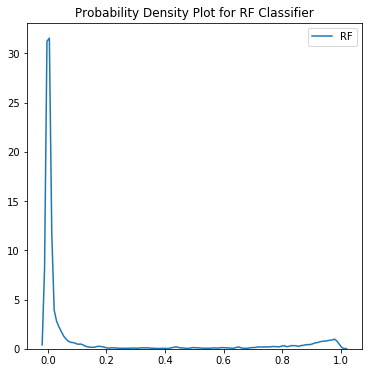

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.kdeplot(pred_prob[:,1],label="RF")

plt.title("Probability Density Plot for RF Classifier")

#### Plot feature importances

In [65]:
# Get numerical feature importances
importances = list(clf_final.feature_importances_)
feature_list = list(X.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances[:20]]

Variable: premis_cd Importance: 0.12
Variable: weapon_used_cd Importance: 0.11
Variable: vict_age Importance: 0.1
Variable: location_2 Importance: 0.09
Variable: location_3 Importance: 0.08
Variable: location_1 Importance: 0.07
Variable: location_4 Importance: 0.06
Variable: weapon_desc_5 Importance: 0.04
Variable: no_rptd_occ Importance: 0.03
Variable: weapon_desc_4 Importance: 0.02
Variable: location_5 Importance: 0.02
Variable: lat Importance: 0.02
Variable: lon Importance: 0.02
Variable: Hour Importance: 0.02
Variable: area_name_1 Importance: 0.01
Variable: vict_sex_1 Importance: 0.01
Variable: vict_descent_2 Importance: 0.01
Variable: vict_descent_4 Importance: 0.01
Variable: premis_desc_4 Importance: 0.01
Variable: premis_desc_5 Importance: 0.01


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

60


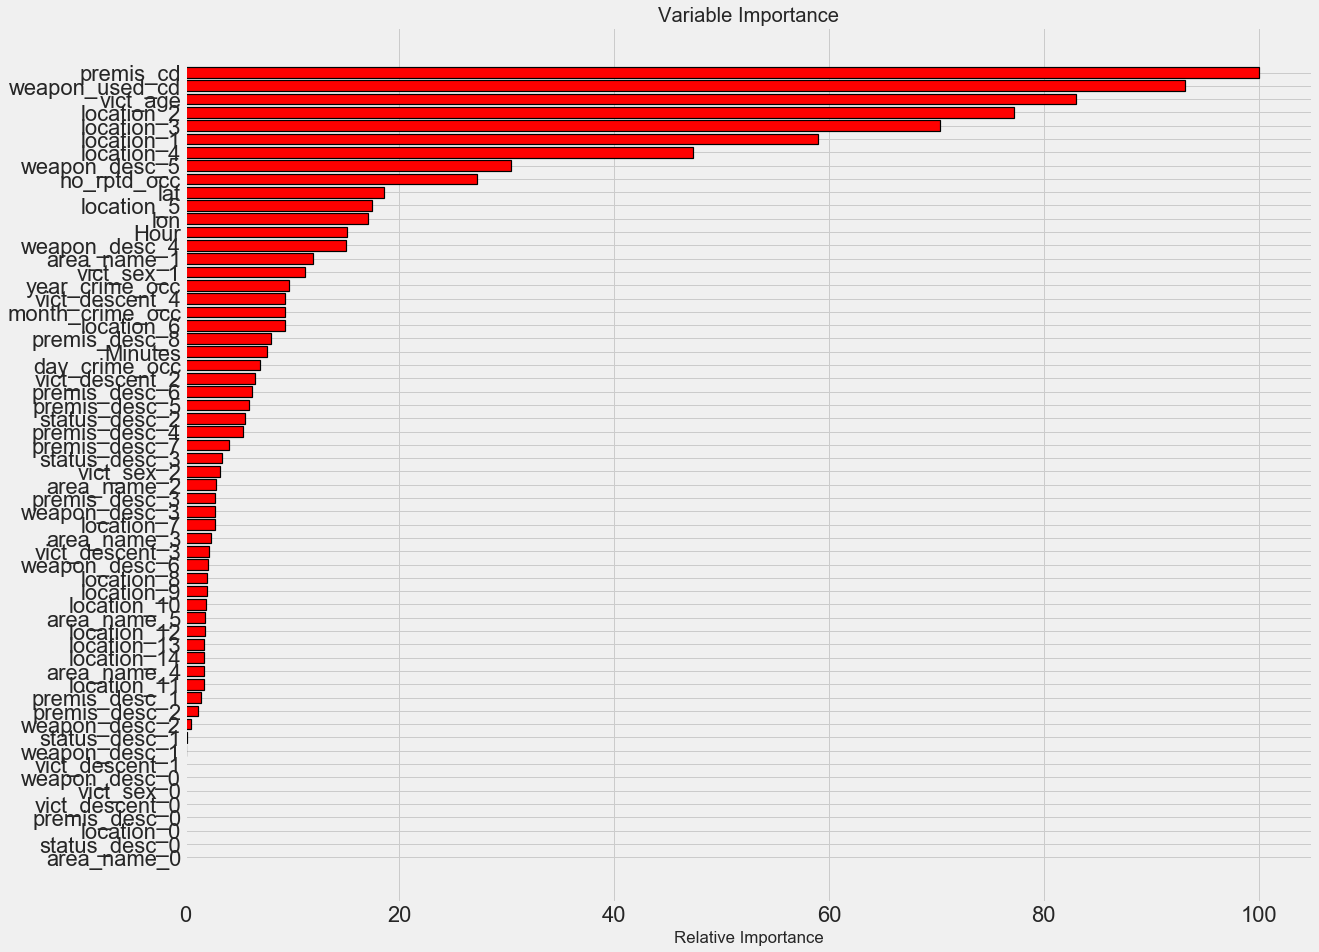

In [66]:
plt.rcParams['font.size'] = 15
plt.style.use('fivethirtyeight')
feature_importance = clf_final.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(18,15))
plt.barh(pos, feature_importance[sorted_idx], align='center',color = 'r', edgecolor = 'k',linewidth = 1.2)
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0.5, 1.0, 'Cumulative Importances')

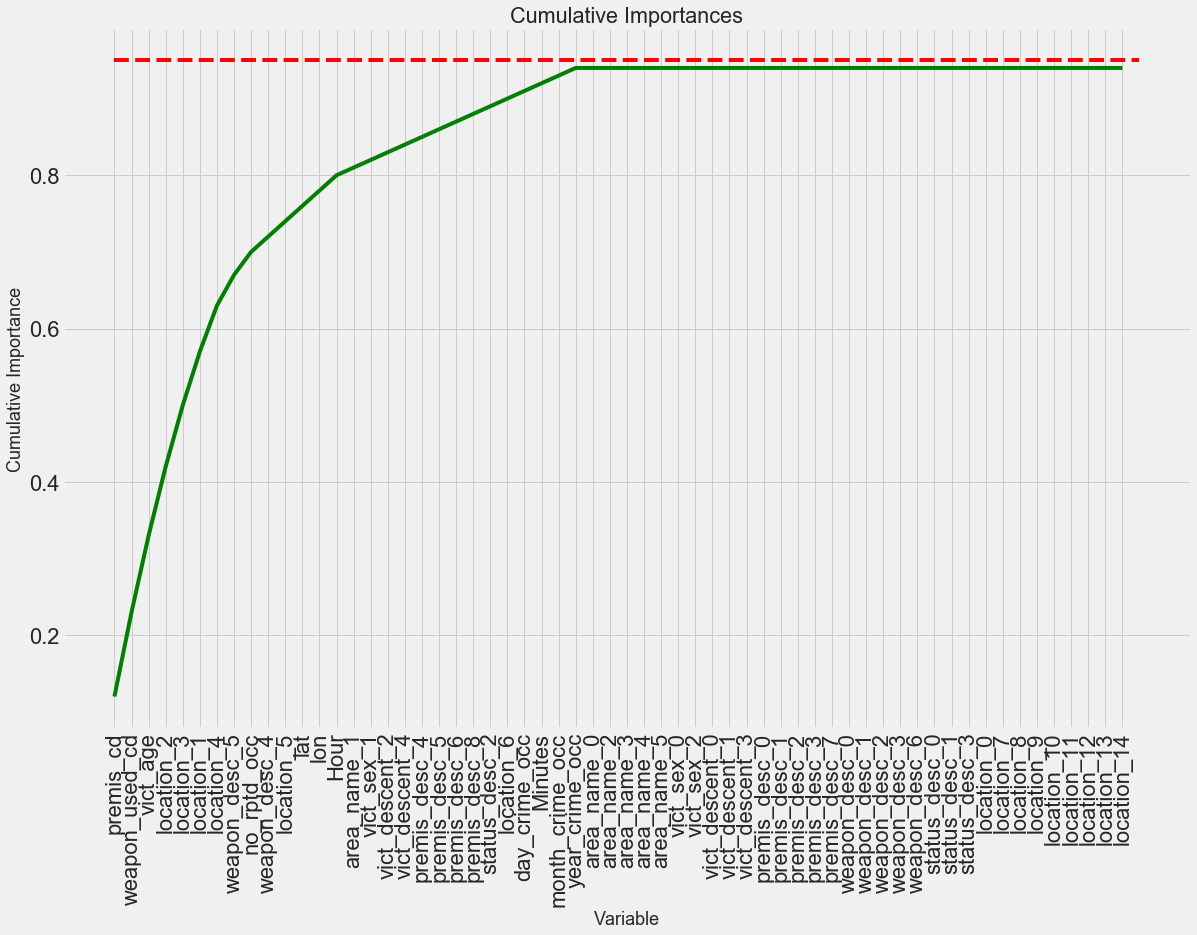

In [70]:
plt.rcParams['font.size'] = 15
plt.subplots(1,1,figsize=(18, 12))
feature_importance = clf_final.feature_importances_
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
x_values = list(range(len(list(clf_final.feature_importances_))))

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance') 
plt.title('Cumulative Importances')

### AUC-ROC for Multi-Class Classification

In [29]:
import itertools

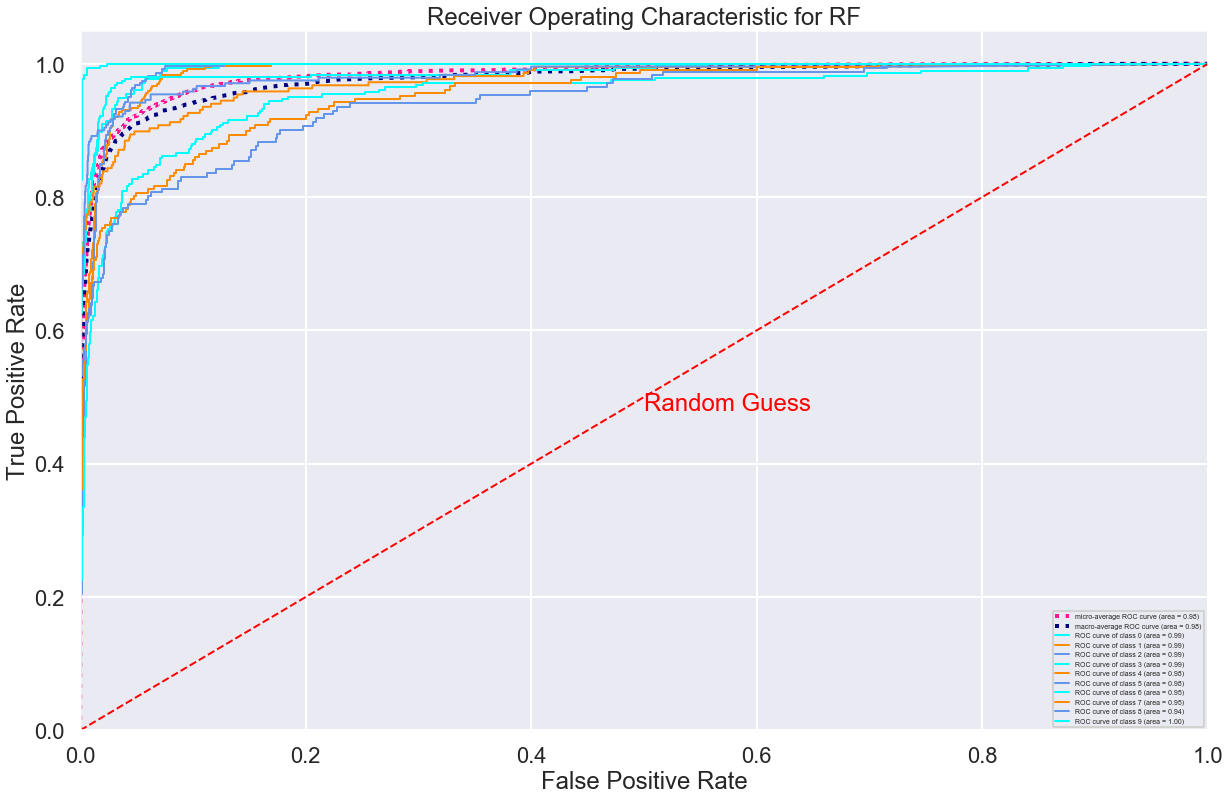

In [38]:
# multi-class classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Learn to predict each class against the other
rf = RandomForestClassifier(n_estimators = 800, min_samples_split = 6, min_samples_leaf = 2, 
                                       max_features = 0.5, max_depth = 35,random_state = 1,n_jobs=-1)
clf = OneVsRestClassifier(rf)
predprob = clf.fit(X_train, y_train).predict_proba(X_test)



# roc curve for classes


n_classes = len(np.unique(y_train))


### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], 
                                  predprob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(pd.get_dummies(y_test)).ravel(), predprob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2

# Plot all ROC curves
plt.figure(figsize=(18,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))


#plt.subplots(1,1,figsize=(18,12))
plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for RF')
plt.legend(loc="lower right", prop={'size': 7})
#plot.legend(loc=2, prop={'size': 6})
plt.show()


#### Confusion Matrix

Confusion matrix, without normalization
[[149  18   1   4   0   2   2   0   0   0]
 [ 14 325   1   9   1   0  10   0   1   0]
 [  1   1 252   2   3   2  16   1   1   0]
 [  0   0   5 292   2   0   6   2   0   0]
 [  2  33   3   2 171   1   2   2   1   0]
 [  0   0  13   2   1 208  11   2   3   0]
 [  1   6  21  12   4  10 223   3   1   2]
 [  1   1   4  20   3   1  20 148   9   0]
 [  0   0   6   8   3   5  13  34  99   3]
 [  0   0   0   0   0   0   2   1   2 298]]
Normalized confusion matrix
[[0.85 0.1  0.01 0.02 0.   0.01 0.01 0.   0.   0.  ]
 [0.04 0.9  0.   0.02 0.   0.   0.03 0.   0.   0.  ]
 [0.   0.   0.9  0.01 0.01 0.01 0.06 0.   0.   0.  ]
 [0.   0.   0.02 0.95 0.01 0.   0.02 0.01 0.   0.  ]
 [0.01 0.15 0.01 0.01 0.79 0.   0.01 0.01 0.   0.  ]
 [0.   0.   0.05 0.01 0.   0.87 0.05 0.01 0.01 0.  ]
 [0.   0.02 0.07 0.04 0.01 0.04 0.79 0.01 0.   0.01]
 [0.   0.   0.02 0.1  0.01 0.   0.1  0.71 0.04 0.  ]
 [0.   0.   0.04 0.05 0.02 0.03 0.08 0.2  0.58 0.02]
 [0.   0.   0.   0.   0.

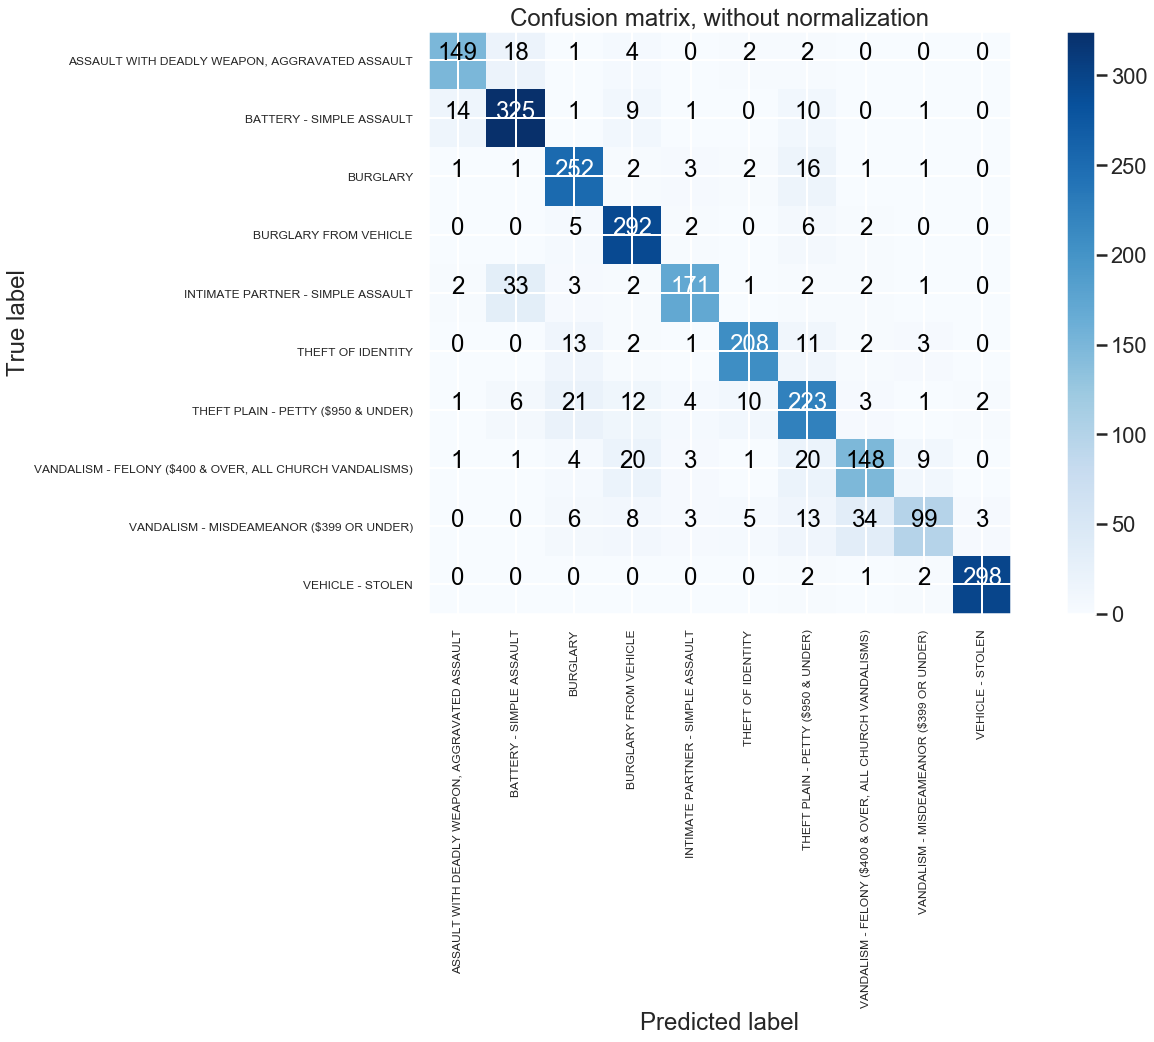

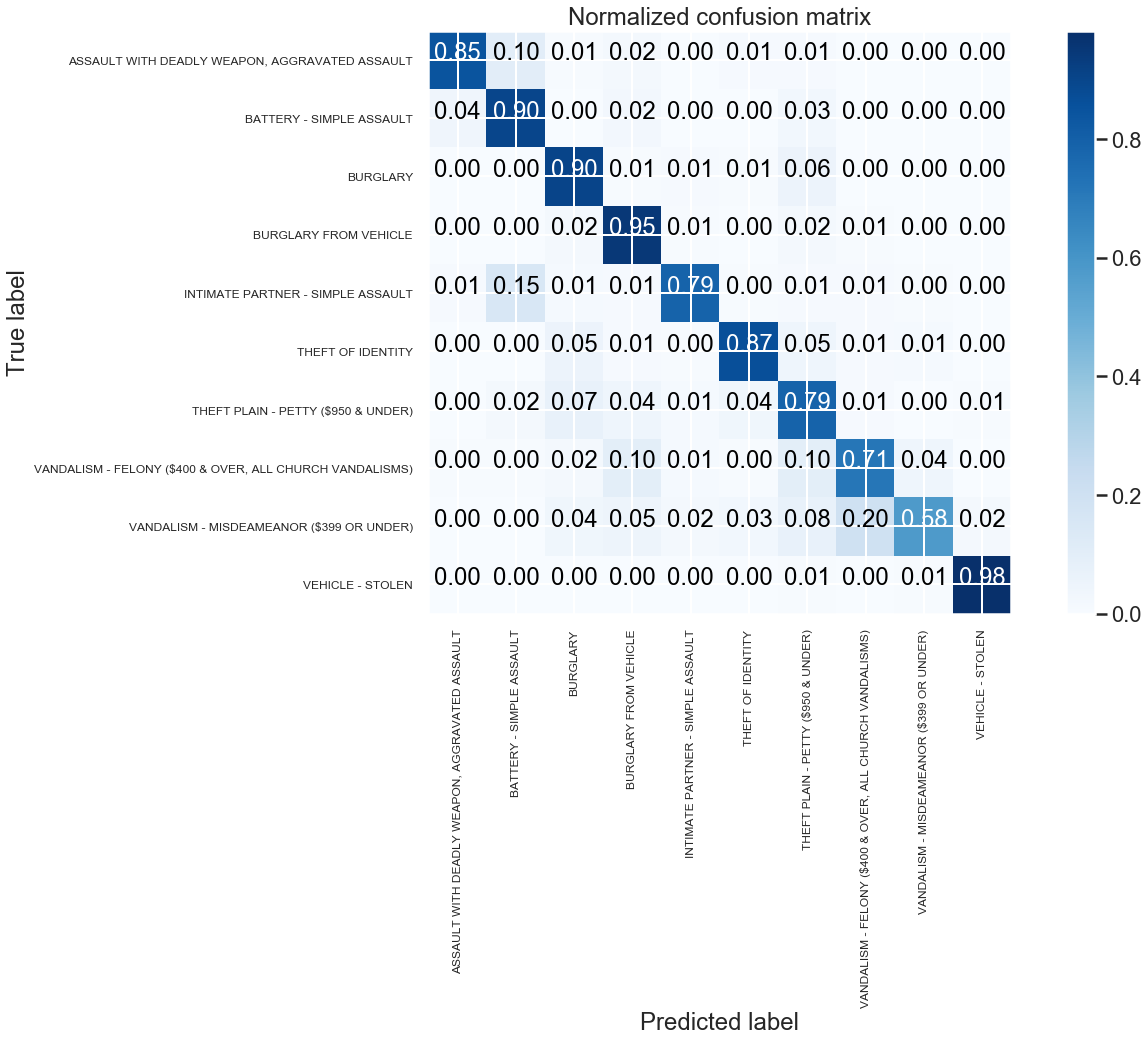

In [53]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

class_names = clf_final.classes_
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize = 12)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (20,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure(figsize = (20,15))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

#### Visualize a single tree from Random forest

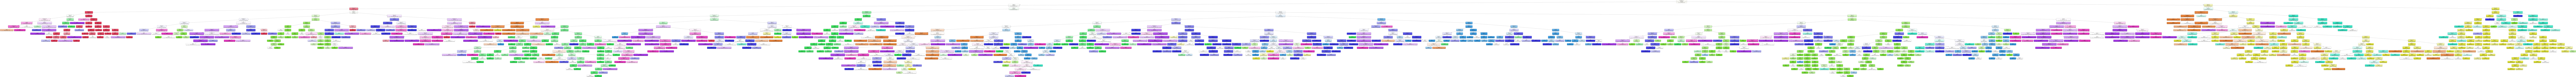

In [64]:
# Extract single tree
estimator = clf_final.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = clf_final.classes_,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


### Conclusion

Our work started with the Data cleaning process,during which we changed the original data column names to more into a more accessible format to make data operations manageable.We also added several useful columns to the original dataset (such as year occurred,month occurred,etc).And dropped the columns which have more than 90% NaN’s.In Exploratory Data Analysis section,we analyzed the dataset using plots such as barplots,box plots and histograms.Furthermore this section has figure out other significant analysis about our dataset, regarding for example the most frequent crimes and weapons used in the city of LA. We also show interesting statistics about crime distribution over years, months, timeslots and weekdays, and some of them were a bit surprising.During the analysis we figured out the outliers and collinear features and removed them.We also revealed that several features, for example location of the crime and the time of the crime, are associated with the type of crime, providing the basis for our modeling later. One single feature may not be sufficient for determining the type of crime, but a combination of various features can be powerful. This is indeed the case in our modeling.


In our modeling, we started with multiclass classification to predict all the crimes including low frequency crimes. And we evaluated several algorithms like SVM,RF,KNN,LogReg(Logistic Regression),XGB with metrics as F1-score(weighted).Even though XGB outperforms RF, we choose RF as our model because of its fast runtime speed and achieved 67%.Since dataset is highly imbalanced, we tried the two of the imbalanced methods.One is Cost sensitive method and other is data sampling algorithm(SMOTETomek). And acheived performance accuracy as 68%,71% respectively.


Then we approached a different method - Classification with DBSCAN(combination of supervised and unsupervised learning algorithms).This was hardest part of our work because we need to find the optimum epsilon and min_sample values for DBSCAN.In this method we used unsupervised method DBSCAN for clustering and also useful to to detect anomalies while clustering and removed the anomalies from the dataset.After that  again we built 3 models using  the above methods and achieved 66%,68%,70% respectively.So our Classification with DBSCAN approach did not any significant results.And we choose the best model as cost sensitive (without cluster) even though SMOTETomek got higher accuracy than cost sensitive because SMOTETomek is computationally so expensive.And we did hyperparameter tuning for better parameters to improve accuracy and were able to increase the performance accuracy by 3% (F1-score(weighted) - 71% ) which pretty good score for highly imbalanced dataset. 
In addition to multiclass classification for all crime types including low frequency crimes,we also tried multiclass classification for high frequency(top 10) crimes.Since we choose high frequency(top 10) crimes, all the classes in target have nearly the same frequency. We evaluated the several machine learning algorithms  like SVM,RF,KNN,LogReg(Logistic Regression),XGB with metrics as F1-score(weighted).Even though XGB outperforms RF, here again I am little biased to RF because if its fast runtime speed we choose RF as our model and achieved  accuracy (f1- score) 83%.After hyperparameter tuning we were able to increase the performance by 1% (F1-score - 84%).


In conclusion, our work led to interesting results, analysis and statistics, but also provided useful tools both for authorities and population, which allows a better understanding of crimes in LA.


### Future Improvements

    In order to boost the classification accuracy, it will be necessary to incorporate other information like Modus Operandi(MO) which we did not use in our model.Additionally, some events and the outcomes of the events may be associated with some crime types.Events information and weather information can also be incorporated.It will be interesting to see whether these features can help the classification.

    We could use a Clustering algorithm, namely K-Modes Clustering, which is similar to K-Means, but uses modes instead of means, making itself usable for cluster computation on categorical variables. As a result of the clustering process, we could figure out some cluster centroids which can potentially be interesting for authorities, since they can indicate "standard frequent crimes", allowing authorities to concentrate their forces in order to contrast crimes indicated by centroids and similar ones.
    
    Due to RAM constraints on Jupyter notebook, I had to train a sample of size 20000 from the original dataset.   Without resource limitations, I would love to train on the full dataset. Preliminary tests showed that the bigger the training size, the higher the accuracy.
